---
---
# **SERIES DE TIEMPO**

Docente: Paulette N. Reyes Baeza

<img src='https://cdn-icons-png.flaticon.com/512/25/25231.png' width=3%>   [Github](https://github.com/paulette-reyes)

---
---
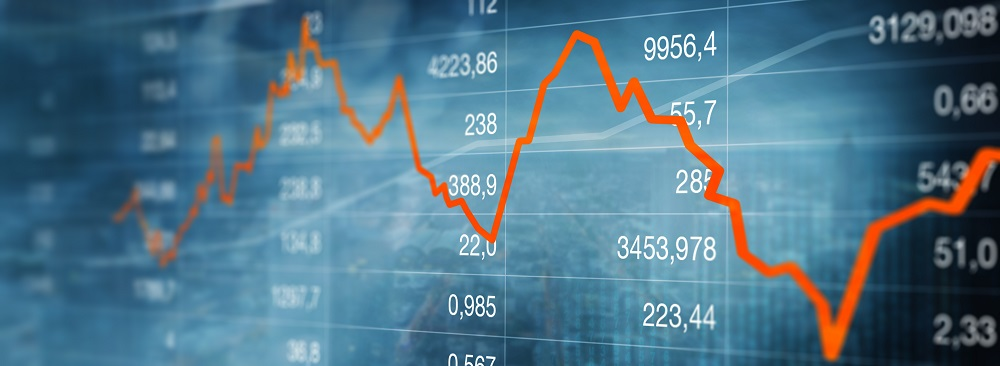

## **Carga de datos**

In [1]:
# Importar librerías básicas
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb
from seaborn import boxplot

🟠 **JUPYTER NOTEBOOK** 🟠

**Opción 1:** Abrir el archivo desde la misma carpeta donde se encuentra el notebook de Jupyter. (Advertencia: El archivo no se subirá si está en otra carpeta diferente)

In [2]:
df = pd.read_csv("Microsoft_Stock.csv")


---


In [3]:
# -------------------- PREPROCESAMIENTO -------------------- #

# Convertir la columna de fecha a formato datetime
df["Date"] = pd.to_datetime(df["Date"])

# Ordenar el DataFrame por la columna 'Date' (de forma ascendente, cronológicamente)
df = df.sort_values(by="Date", ascending=True)

# Establecer fecha como índice del df
df.set_index("Date", inplace=True)

In [4]:
#Primeros registros
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


# **2. MODELOS ESTOCÁSTICOS**
---

Un modelo estocástico escribe matemáticamente la evolución de un sistema a lo largo del tiempo, la cual está sujeta a la influencia de variables aleatorias. Estos modelos son capaces de capturar la aleatoriedad o la variabilidad (incertidumbre) inherente en los datos que está tratando de describir o predecir.



## **2.1. Preparación de la serie**

In [5]:
# Eliminar las columnas que no se van a utilizar
df = df.drop(columns=["Open","High","Low"])

In [6]:
df.head(10)

,Close,Volume
Date,,
2015-04-01 16:00:00,40.72,36865322
2015-04-02 16:00:00,40.29,37487476
2015-04-06 16:00:00,41.55,39223692
2015-04-07 16:00:00,41.53,28809375
2015-04-08 16:00:00,41.42,24753438
2015-04-09 16:00:00,41.48,25723861
2015-04-10 16:00:00,41.72,28022002
2015-04-13 16:00:00,41.76,30276692
2015-04-14 16:00:00,41.65,24244382


Cuando las fechas no son continuas, muchas veces es necesario agregar las fechas faltantes.

```
# Rango de fechas para rellenar los dias faltantes
df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='D'))

# Asignar frecuencia
df.index.freq = 'D'  # Asigna la frecuencia diaria

# Imputar los valores nulos de los dias faltantes
df['Close'] = df['Close'].interpolate(method='linear')
df['Volume'] = df['Volume'].interpolate(method='linear')
```
El problema de este enfoque es que es necesario imputar los datos nulos de la serie generados por el nuevo rango de fechas, y dependiendo de la técnica utilizada para imputar, puede introducir un sesgo en las predicciones.




**Transformación:**

➡️ `diff()`: Calcula la diferencia entre un elemento y el anterior de la serie de tiempo. Se usa para transformar una serie no estacionaria en una estacionaria, eliminando tendencias o patrones de largo plazo.


```
# Diferenciación para estacionarizar la serie
df['Close_diff'] = df['Close_log'].diff()

# Eliminación del primer registro nulo
df = df.dropna()
```

Se debe evaluar la necesidad de diferenciar la serie, ya que aunque esta no sea estacionaria, a veces el proceso de diferenciación puede sobre estabilizar la serie y que tenga un comportamiento muy plano.


➡️ `log()`: Transformación logarítmica reduce el impacto de valores extremos y estabiliza la varianza de la serie, haciendo que sea más estacionaria, pero el cambio es más suave que con la diferenciación.

In [7]:
# Transformación logarítmica
df['Close_log'] = np.log(df['Close'])
df['Volume_log'] = np.log(df['Volume'])

**Split**

Se realiza una separación (split) del set de datos en *conjunto de entrenamiento* y *conjunto de prueba*. Se utiliza la mayoría del dataset para alimentar el modelo, por lo que el conjunto de entrenamiento contiene la  mayoría de los datos. Por lo general la proporción de los datos es entre 70/30, 80/20 o 90/10.

> *   Conjunto de Entrenamiento (train): Porción de los datos que se utilizará para el entrenamiento del modelo.
> *   Conjunto de Prueba/Validación (test): Porción de los datos que se utilizará en el modelo para realizar predicciones y validar los resultados.

Realizar esta división del set de datos ayuda a evitar o corregir errores de sobreajuste (overfitting) y subajuste (underfitting) que pueda tener el modelo.

In [8]:
# Proporción de datos de entrenamiento 80/20
train_size = int(len(df) * 0.8)

# Dividir los datos
train, test = df[:train_size], df[train_size:]

print(f'Train set: {train.shape}')
print(f'Test set: {test.shape}')

Train set: (1208, 4)
Test set: (303, 4)


Se define la variable objetivo, es decir, la serie de tiempo que se quiere modelar (y)

In [9]:
# Definir variable objetivo
y_train = train['Close_log']
y_test = test['Close_log']

In [10]:
# Últimas fechas del conjunto de entrenamiento
y_train.tail()

Date
2020-01-10 16:00:00    5.083514
2020-01-13 16:00:00    5.095467
2020-01-14 16:00:00    5.088398
2020-01-15 16:00:00    5.094854
2020-01-16 16:00:00    5.113011
Name: Close_log, dtype: float64

In [11]:
# Primeras fechas del conjunto de prueba
y_test.head()

Date
2020-01-17 16:00:00    5.118592
2020-01-21 16:00:00    5.114995
2020-01-22 16:00:00    5.110179
2020-01-23 16:00:00    5.116316
2020-01-24 16:00:00    5.106188
Name: Close_log, dtype: float64

## **2.2. Modelo AR(p)**

In [12]:
# Importar librerías necesarias

# Modelos
from statsmodels.tsa.ar_model import AutoReg

# Metricas de evaluacion
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes 

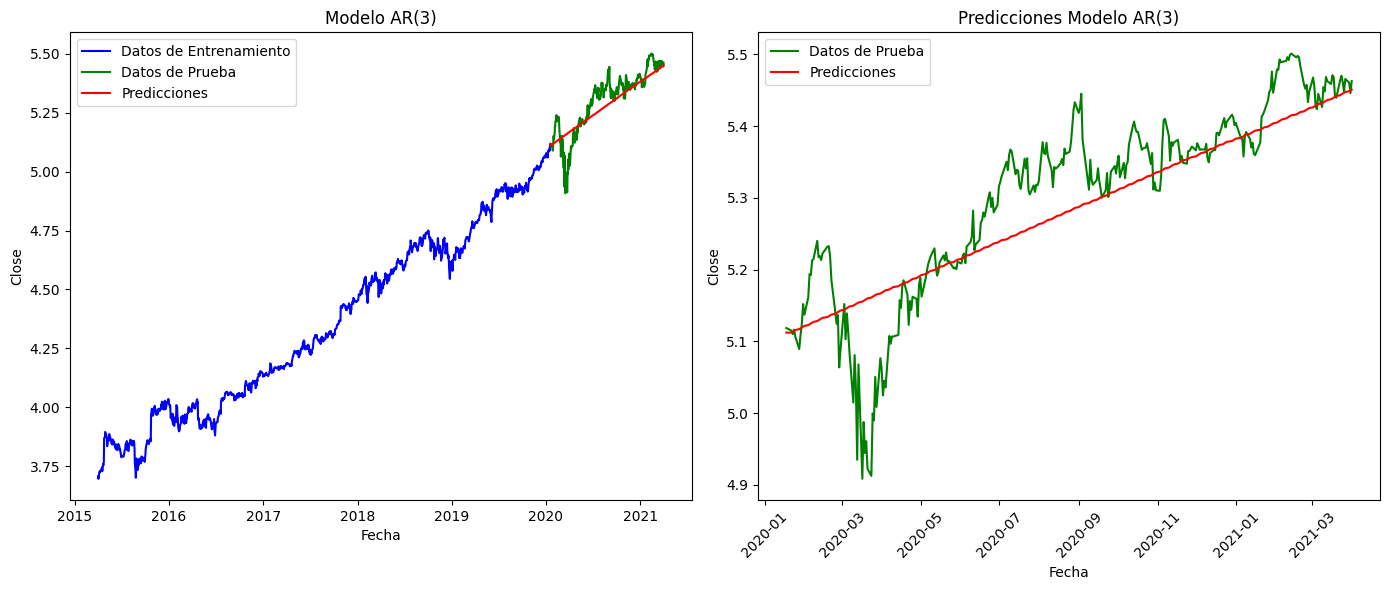

In [13]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo AR con los datos de entrenamiento
modelo_AR = AutoReg(y_train, lags=3)  # Número de rezagos (lag) en el modelo AR
result_AR = modelo_AR.fit()

# Hacer predicciones en el conjunto de prueba
pred_AR = result_AR.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_AR, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo AR(3)")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_AR, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo AR(3)")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [14]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_AR = mean_absolute_error(y_test, pred_AR)
mape_AR = mean_absolute_percentage_error(y_test, pred_AR)
rmse_AR = rmse(y_test, pred_AR)
rmspe_AR = rmspe(y_test, pred_AR)
r2_AR = r2_score(y_test, pred_AR)
aic_AR = result_AR.aic
bic_AR = result_AR.bic

# Imprimir las métricas
print(f"MAE: {mae_AR:.2f}")
print(f"MAPE: {mape_AR:.2f}%")
print(f"RMSE: {rmse_AR:.2f}")
print(f"RMSPE: {rmspe_AR:.2f}%")
print(f"r2: {r2_AR:.2f}")
print(f"AIC: {aic_AR}")
print(f"BIC: {bic_AR}")

MAE: 0.05
MAPE: 0.01%
RMSE: 0.07
RMSPE: 0.13%
r2: 0.74
AIC: -6805.308885559999
BIC: -6779.837711330375


## **2.3. Modelo MA(q)**

In [15]:
# Importar librerías necesarias

# Modelos
from statsmodels.tsa.arima.model import ARIMA

/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. 

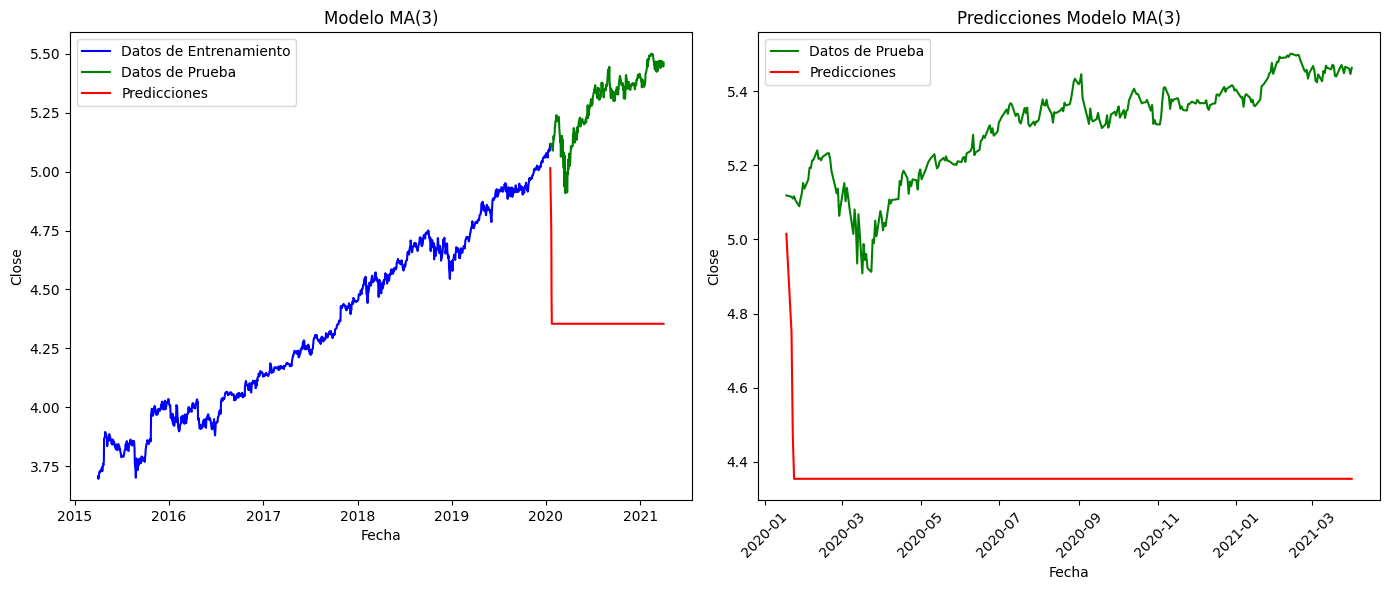

In [16]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo MA con los datos de entrenamiento
modelo_MA = ARIMA(y_train, order=(0, 0, 3))  # (p=0, d=0, q=3) para un modelo MA con 3 rezagos
result_MA = modelo_MA.fit()

# Hacer predicciones en el conjunto de prueba
pred_MA = result_MA.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_MA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo MA(3)")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_MA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo MA(3)")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [17]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_MA = mean_absolute_error(y_test, pred_MA)
mape_MA = mean_absolute_percentage_error(y_test, pred_MA)
rmse_MA = rmse(y_test, pred_MA)
rmspe_MA = rmspe(y_test, pred_MA)
r2_MA = r2_score(y_test, pred_MA)
aic_MA = result_MA.aic
bic_MA = result_MA.bic

# Imprimir las métricas
print(f"MAE: {mae_MA:.2f}")
print(f"MAPE: {mape_MA:.2f}%")
print(f"RMSE: {rmse_MA:.2f}")
print(f"RMSPE: {rmspe_MA:.2f}%")
print(f"r2: {r2_MA:.2f}")
print(f"AIC: {aic_MA}")
print(f"BIC: {bic_MA}")

MAE: 0.94
MAPE: 0.18%
RMSE: 0.95
RMSPE: 1.79%
r2: -51.09
AIC: -2832.4365629310087
BIC: -2806.952956038535


## **2.4. Modelo ARMA(p,q)**

/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. 

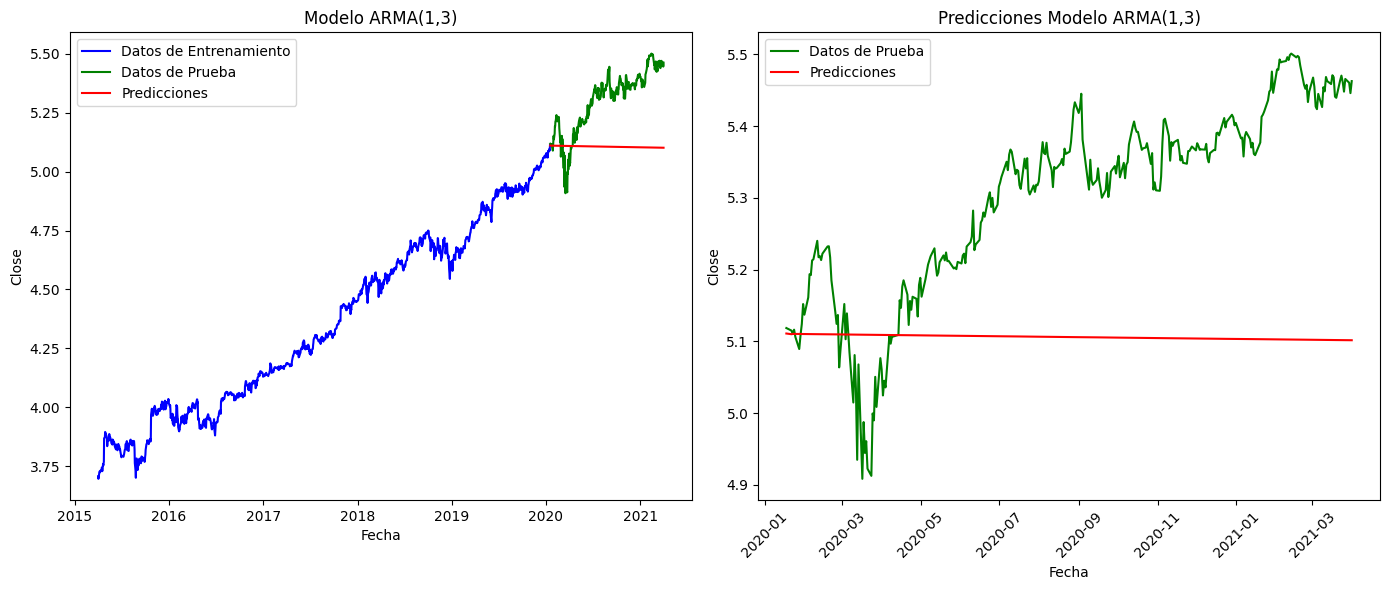

In [18]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo ARMA con los datos de entrenamiento
modelo_ARMA = ARIMA(y_train, order=(1, 0, 3))  # (p=1, d=0, q=3) para un modelo ARMA con AR(1) y MA(3)
result_ARMA = modelo_ARMA.fit()

# Hacer predicciones en el conjunto de prueba
pred_ARMA = result_ARMA.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo ARMA(1,3)")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo ARMA(1,3)")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [19]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_ARMA = mean_absolute_error(y_test, pred_ARMA)
mape_ARMA = mean_absolute_percentage_error(y_test, pred_ARMA)
rmse_ARMA = rmse(y_test, pred_ARMA)
rmspe_ARMA = rmspe(y_test, pred_ARMA)
r2_ARMA = r2_score(y_test, pred_ARMA)
aic_ARMA = result_ARMA.aic
bic_ARMA = result_ARMA.bic

# Imprimir las métricas
print(f"MAE: {mae_ARMA:.2f}")
print(f"MAPE: {mape_ARMA:.2f}%")
print(f"RMSE: {rmse_ARMA:.2f}")
print(f"RMSPE: {rmspe_ARMA:.2f}%")
print(f"r2: {r2_ARMA:.2f}")
print(f"AIC: {aic_ARMA}")
print(f"BIC: {bic_ARMA}")

MAE: 0.21
MAPE: 0.04%
RMSE: 0.24
RMSPE: 0.44%
r2: -2.19
AIC: -6799.047445250987
BIC: -6768.467116980019


## **2.5. Modelo ARIMA(p,d,q)**

/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. 

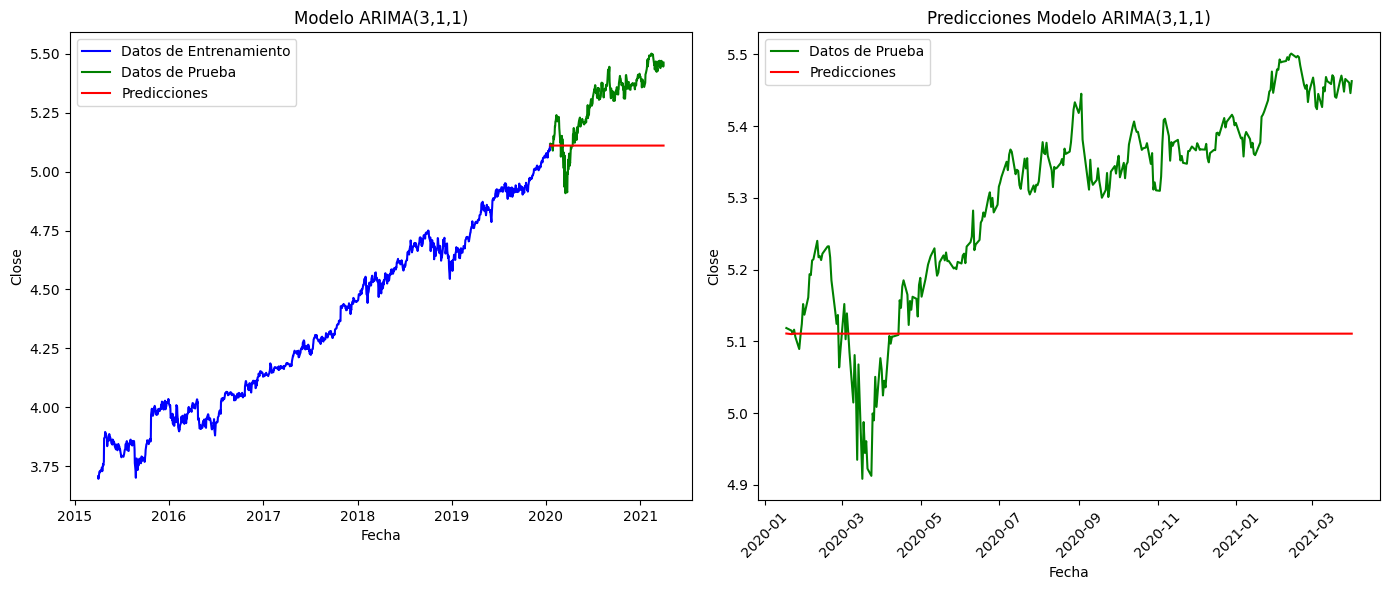

In [20]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo ARIMA con los datos de entrenamiento
modelo_ARIMA = ARIMA(y_train, order=(3, 1, 1))  # (p=1, d=1, q=1) para un modelo ARIMA con AR(3), diferencia de grado 1 y MA(1)
result_ARIMA = modelo_ARIMA.fit()

# Hacer predicciones en el conjunto de prueba
#pred_ARIMA = result_ARIMA.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

pred_ARIMA = result_ARIMA.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')  # typ='levels' para obtener las predicciones originales y no las diferencias

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo ARIMA(3,1,1)")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo ARIMA(3,1,1)")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [21]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_ARIMA = mean_absolute_error(y_test, pred_ARIMA)
mape_ARIMA = mean_absolute_percentage_error(y_test, pred_ARIMA)
rmse_ARIMA = rmse(y_test, pred_ARIMA)
rmspe_ARIMA = rmspe(y_test, pred_ARIMA)
r2_ARIMA = r2_score(y_test, pred_ARIMA)
aic_ARIMA = result_ARIMA.aic
bic_ARIMA = result_ARIMA.bic


# Imprimir las métricas
print(f"MAE: {mae_ARIMA:.2f}")
print(f"MAPE: {mape_ARIMA:.2f}%")
print(f"RMSE: {rmse_ARIMA:.2f}")
print(f"RMSPE: {rmspe_ARIMA:.2f}%")
print(f"r2: {r2_ARIMA:.2f}")
print(f"AIC: {aic_ARIMA}")
print(f"BIC: {bic_ARIMA}")

MAE: 0.20
MAPE: 0.04%
RMSE: 0.23
RMSPE: 0.43%
r2: -2.05
AIC: -6804.247597439612
BIC: -6778.7681313341245


In [22]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.1 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 2.6 MB/s eta 0:00:00a 0:00:01m


In [23]:
# Importar librerías necesarias

# Modelos
from pmdarima import auto_arima

/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6812.157, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6804.349, Time=0.10 sec


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6811.007, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6812.298, Time=0.17 sec


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6798.493, Time=0.13 sec


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6814.300, Time=0.43 sec


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6814.663, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6815.948, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6814.458, Time=0.10 sec


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6812.369, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6807.322, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.210 seconds


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predi

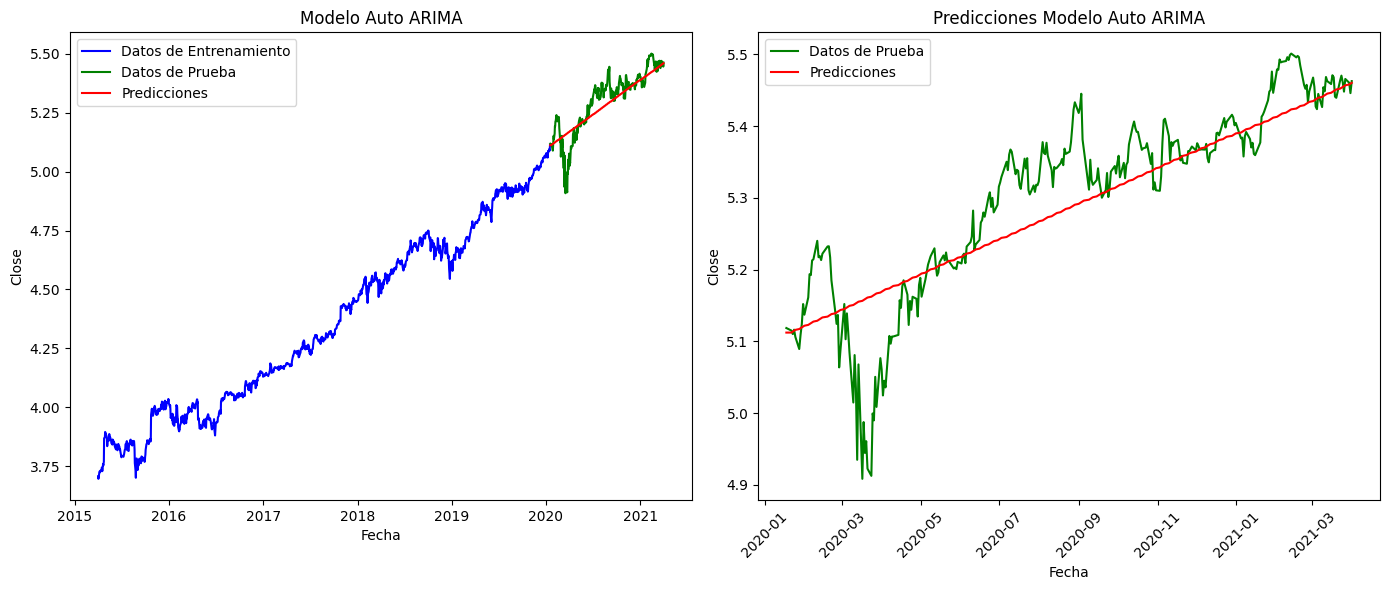

In [24]:
# -------------------- MODELAMIENTO -------------------- #

# Aplicar auto_arima para seleccionar el mejor modelo ARIMA
auto_ARIMA = auto_arima(y_train, seasonal=False, stepwise=True, trace=True)

# Ajustar el modelo ARIMA seleccionado
result_AutoARIMA = auto_ARIMA.fit(y_train)

# Hacer predicciones
pred_AutoARIMA = result_AutoARIMA.predict(n_periods=len(y_test))

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_AutoARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo Auto ARIMA")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_AutoARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo Auto ARIMA")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [25]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_AutoARIMA = mean_absolute_error(y_test, pred_AutoARIMA)
mape_AutoARIMA = mean_absolute_percentage_error(y_test, pred_AutoARIMA)
rmse_AutoARIMA = rmse(y_test, pred_AutoARIMA)
rmspe_AutoARIMA = rmspe(y_test, pred_AutoARIMA)
r2_AutoARIMA = r2_score(y_test, pred_AutoARIMA)
aic_AutoARIMA = auto_ARIMA.aic()
bic_AutoARIMA = auto_ARIMA.bic()


# Imprimir las métricas
print(f"MAE: {mae_AutoARIMA:.2f}")
print(f"MAPE: {mape_AutoARIMA:.2f}%")
print(f"RMSE: {rmse_AutoARIMA:.2f}")
print(f"RMSPE: {rmspe_AutoARIMA:.2f}%")
print(f"r2: {r2_AutoARIMA:.2f}")
print(f"AIC: {aic_AutoARIMA}")
print(f"BIC: {bic_AutoARIMA}")

MAE: 0.05
MAPE: 0.01%
RMSE: 0.07
RMSPE: 0.13%
r2: 0.76
AIC: -6815.947674086905
BIC: -6795.564101202514


In [26]:
auto_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1208
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3411.974
Date:                Fri, 20 Dec 2024   AIC                          -6815.948
Time:                        20:15:30   BIC                          -6795.564
Sample:                             0   HQIC                         -6808.272
                               - 1208                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.000      3.214      0.001       0.001       0.002
ar.L1         -0.0897      0.020     -4.428      0.000      -0.129      -0.050
ar.L2         -0.0757      0.023     -3.329      0.001      -0.120      -0.031
sigma2         0.0002   4.19e-06     48.922      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1838.62
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.24
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **2.6. Modelo SARIMA(p,d,q)(P,D,Q,s)**

In [27]:
# Importar librerías necesarias
from statsmodels.tsa.statespace.sarimax import SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.49199D+00    |proj g|=  1.61846D+01


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.54278D+00    |proj g|=  1.06878D-01

At iterate   10    f= -2.54507D+00    |proj g|=  4.23946D+00

At iterate   15    f= -2.55782D+00    |proj g|=  6.54294D-02

At iterate   20    f= -2.57056D+00    |proj g|=  7.57145D+00

At iterate   25    f= -2.58848D+00    |proj g|=  2.96085D-01

At iterate   30    f= -2.61389D+00    |proj g|=  1.31722D-01

At iterate   35    f= -2.61420D+00    |proj g|=  9.40116D-02

At iterate   40    f= -2.61424D+00    |proj g|=  4.87611D-03

At iterate   45    f= -2.61428D+00    |proj g|=  2.76403D-02

At iterate   50    f= -2.61515D+00    |proj g|=  3.45068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


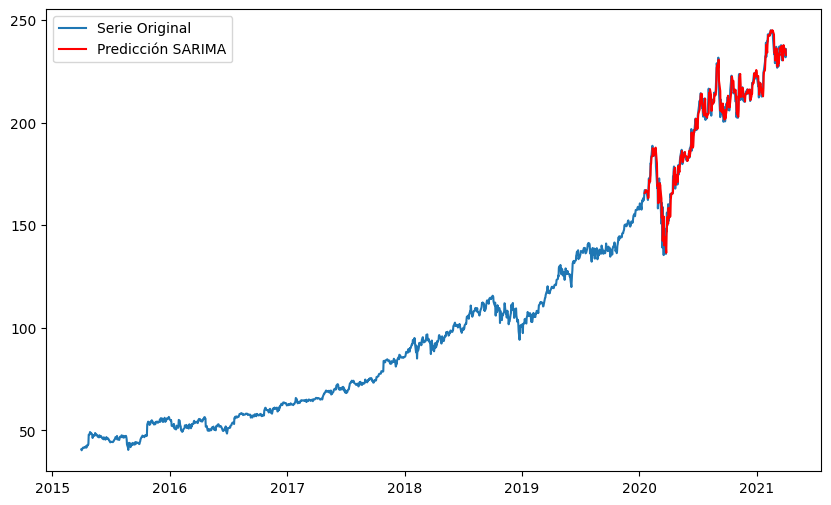

In [28]:
# Ajustar SARIMA (prueba con diferentes órdenes)
model_sarima = SARIMAX(df['Close_log'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()

# Predicciones
y_pred_sarima_log = model_sarima.predict(start=len(train), end=len(train)+len(test)-1)
y_pred_sarima = np.exp(y_pred_sarima_log)  # Revertir logaritmo

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label="Serie Original")
plt.plot(df.index[train_size:], y_pred_sarima, label="Predicción SARIMA", color='red')
plt.legend()
plt.show()


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.67204D+00    |proj g|=  2.03067D+01

At iterate    5    f= -2.73098D+00    |proj g|=  1.26663D-01

At iterate   10    f= -2.73331D+00    |proj g|=  4.88134D+00

At iterate   15    f= -2.74533D+00    |proj g|=  5.09921D-02

At iterate   20    f= -2.76324D+00    |proj g|=  4.08410D+00

At iterate   25    f= -2.79185D+00    |proj g|=  6.78638D-01

At iterate   30    f= -2.79420D+00    |proj g|=  6.57389D-01

At iterate   35    f= -2.79638D+00    |proj g|=  4.40238D-01

At iterate   40    f= -2.79661D+00    |proj g|=  2.54454D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43    102      2     0     0   2.164D-02  -2.797D+00
  F =  -2.7966070582980755     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


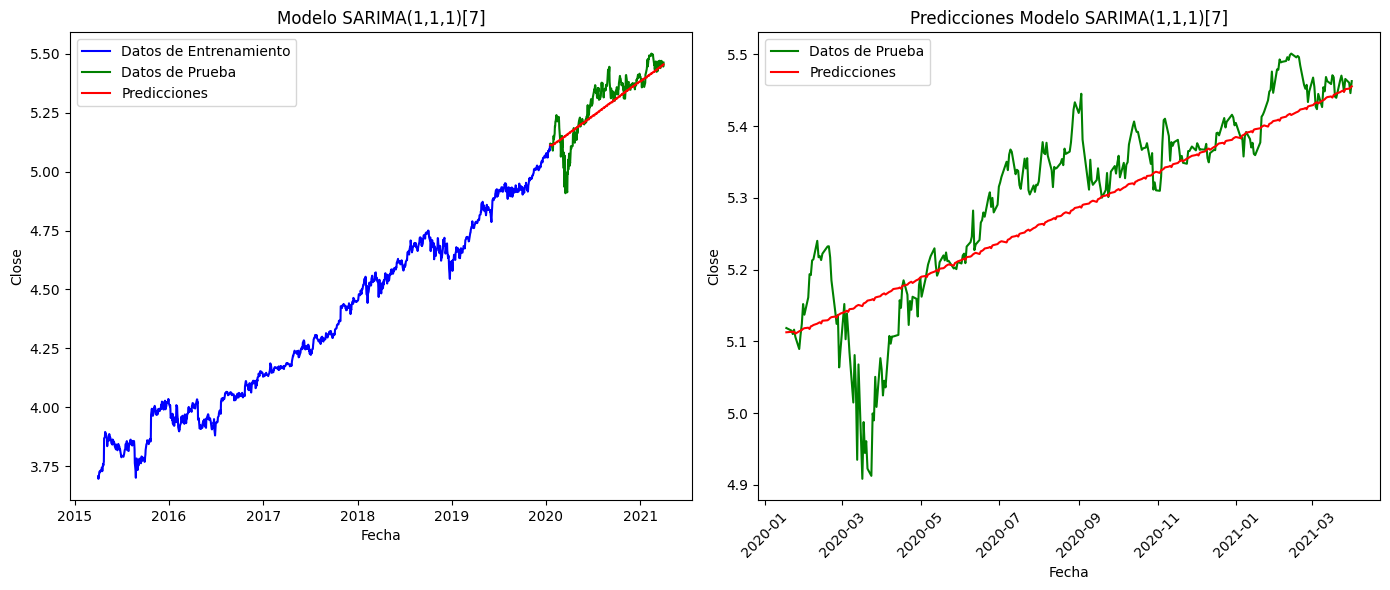

In [29]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo SARIMA con los datos de entrenamiento
modelo_SARIMA = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
result_SARIMA = modelo_SARIMA.fit()

# Hacer predicciones en el conjunto de prueba
pred_SARIMA = result_SARIMA.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1 ) #typ='levels'

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_SARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo SARIMA(1,1,1)[7]")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_SARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo SARIMA(1,1,1)[7]")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [30]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_SARIMA = mean_absolute_error(y_test, pred_SARIMA)
mape_SARIMA = mean_absolute_percentage_error(y_test, pred_SARIMA)
rmse_SARIMA = rmse(y_test, pred_SARIMA)
rmspe_SARIMA = rmspe(y_test, pred_SARIMA)
r2_SARIMA = r2_score(y_test, pred_SARIMA)
aic_SARIMA = result_SARIMA.aic
bic_SARIMA = result_SARIMA.bic

# Imprimir las métricas
print(f"MAE: {mae_SARIMA:.2f}")
print(f"MAPE: {mape_SARIMA:.2f}%")
print(f"RMSE: {rmse_SARIMA:.2f}")
print(f"RMSPE: {rmspe_SARIMA:.2f}%")
print(f"r2: {r2_SARIMA:.2f}")
print(f"AIC: {aic_SARIMA}")
print(f"BIC: {bic_SARIMA}")

MAE: 0.05
MAPE: 0.01%
RMSE: 0.07
RMSPE: 0.13%
r2: 0.74
AIC: -6746.602652848151
BIC: -6721.152268669271


## **2.7. Modelo ARIMAX(p,d,q)**

Para intentar mejorar los resultados de predicción, se incorporan variables exógenas al modelo.

Se utilizará otra variable del dataset como variable independiente (X).

In [31]:
# Sólo la columna Volume se consideraría variable exógena
X_train = train["Volume_log"]
X_test = test["Volume_log"]

In [32]:
X_train.tail()

Date
2020-01-10 16:00:00    16.847283
2020-01-13 16:00:00    16.889916
2020-01-14 16:00:00    16.972544
2020-01-15 16:00:00    16.879736
2020-01-16 16:00:00    16.987939
Name: Volume_log, dtype: float64

In [33]:
X_test.head()

Date
2020-01-17 16:00:00    17.352743
2020-01-21 16:00:00    17.200483
2020-01-22 16:00:00    16.999330
2020-01-23 16:00:00    16.795152
2020-01-24 16:00:00    17.031106
Name: Volume_log, dtype: float64

/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. 

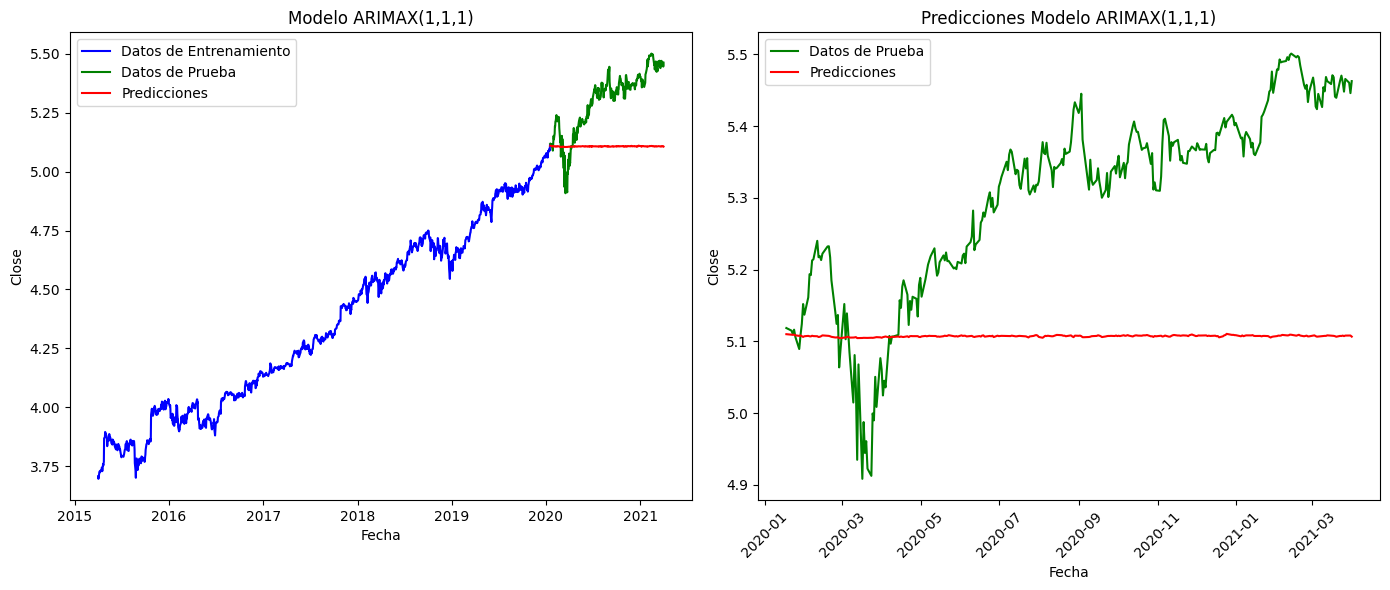

In [34]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo ARIMAX con los datos de entrenamiento
modelo_ARIMAX = ARIMA(y_train, order=(1, 1, 1), exog=X_train)
result_ARIMAX = modelo_ARIMAX.fit()

# Hacer predicciones en el conjunto de prueba
pred_ARIMAX = result_ARIMAX.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARIMAX, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo ARIMAX(1,1,1)")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARIMAX, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo ARIMAX(1,1,1)")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [35]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_ARIMAX = mean_absolute_error(y_test, pred_ARIMAX)
mape_ARIMAX = mean_absolute_percentage_error(y_test, pred_ARIMAX)
rmse_ARIMAX = rmse(y_test, pred_ARIMAX)
rmspe_ARIMAX = rmspe(y_test, pred_ARIMAX)
r2_ARIMAX = r2_score(y_test, pred_ARIMAX)
aic_ARIMAX = result_ARIMAX.aic
bic_ARIMAX = result_ARIMAX.bic

# Imprimir las métricas
print(f"MAE: {mae_ARIMAX:.2f}")
print(f"MAPE: {mape_ARIMAX:.2f}")
print(f"RMSE: {rmse_ARIMAX:.2f}")
print(f"RMSPE: {rmspe_ARIMAX:.2f}")
print(f"r2: {r2_ARIMAX:.2f}")
print(f"AIC: {aic_ARIMAX}")
print(f"BIC: {bic_ARIMAX}")

MAE: 0.21
MAPE: 0.04
RMSE: 0.23
RMSPE: 0.43
r2: -2.12
AIC: -6810.249685924154
BIC: -6789.866113039763


## **2.8. Modelo SARIMAX(p,d,q)(P,D,Q,s)**

In [36]:
# Importar librerías necesarias
from statsmodels.tsa.statespace.sarimax import SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.67506D+00    |proj g|=  2.04176D+01


/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.73443D+00    |proj g|=  1.28928D-01

At iterate   10    f= -2.73642D+00    |proj g|=  4.58623D+00

At iterate   15    f= -2.74903D+00    |proj g|=  1.46233D-01

At iterate   20    f= -2.74922D+00    |proj g|=  3.15853D-01

At iterate   25    f= -2.75335D+00    |proj g|=  2.23690D+00

At iterate   30    f= -2.75524D+00    |proj g|=  2.80246D-01

At iterate   35    f= -2.78044D+00    |proj g|=  1.49911D+00

At iterate   40    f= -2.79376D+00    |proj g|=  3.12044D-01

At iterate   45    f= -2.79670D+00    |proj g|=  2.12002D-01

At iterate   50    f= -2.79844D+00    |proj g|=  2.15774D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/gonz4/python/series_de_tiempo/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


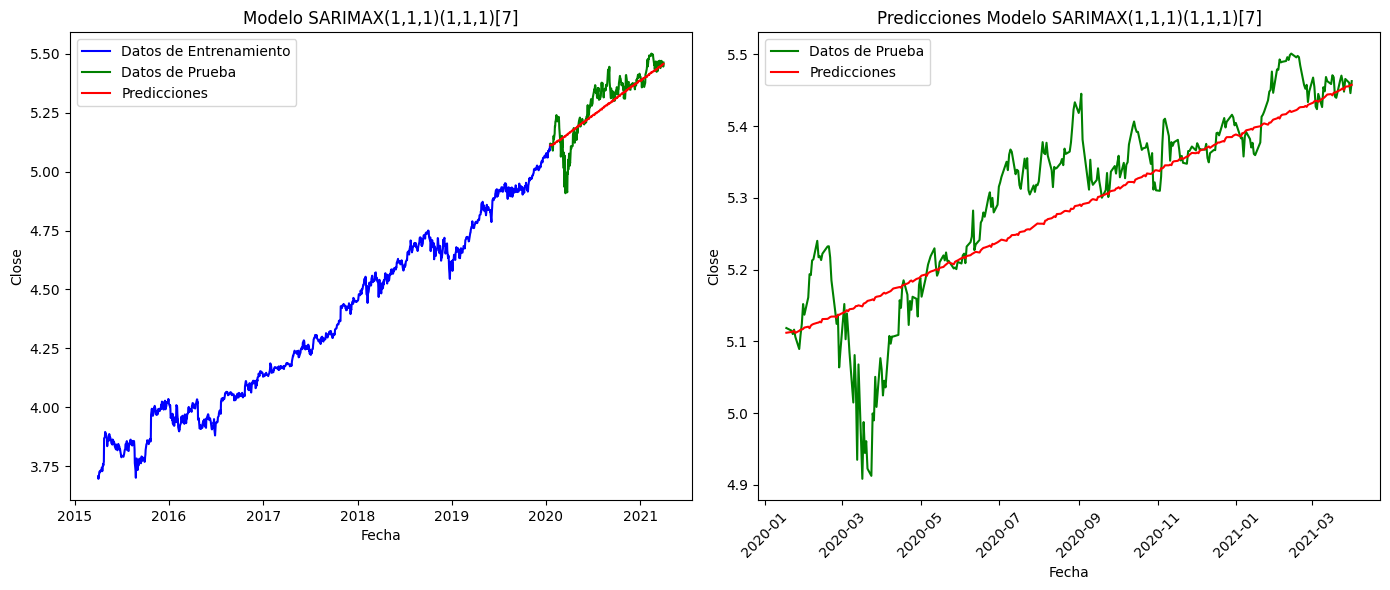

In [37]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo SARIMAX con los datos de entrenamiento
modelo_SARIMAX = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
result_SARIMAX = modelo_SARIMAX.fit()

# Hacer predicciones en el conjunto de prueba
pred_SARIMAX = result_SARIMAX.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_SARIMAX, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo SARIMAX(1,1,1)(1,1,1)[7]")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_SARIMAX, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo SARIMAX(1,1,1)(1,1,1)[7]")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [38]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_SARIMAX = mean_absolute_error(y_test, pred_SARIMAX)
mape_SARIMAX = mean_absolute_percentage_error(y_test, pred_SARIMAX)
rmse_SARIMAX = rmse(y_test, pred_SARIMAX)
rmspe_SARIMAX = rmspe(y_test, pred_SARIMAX)
r2_SARIMAX = r2_score(y_test, pred_SARIMAX)
aic_SARIMAX = result_SARIMAX.aic
bic_SARIMAX = result_SARIMAX.bic

# Imprimir las métricas
print(f"MAE: {mae_SARIMAX:.2f}")
print(f"MAPE: {mape_SARIMAX:.2f}%")
print(f"RMSE: {rmse_SARIMAX:.2f}")
print(f"RMSPE: {rmspe_SARIMAX:.2f}%")
print(f"r2: {r2_SARIMAX:.2f}")
print(f"AIC: {aic_SARIMAX}")
print(f"BIC: {bic_SARIMAX}")

MAE: 0.05
MAPE: 0.01%
RMSE: 0.07
RMSPE: 0.13%
r2: 0.75
AIC: -6749.039313772111
BIC: -6718.498852757455
